# **Lab 4: Neural Networks (II)**


Intagliata Emanuele (928166)

Surricchio Mattia (920715)

Link: https://colab.research.google.com/drive/1aX5FEUi7oO4oCHlANGWBX_aRerYixkeD#scrollTo=-OaCQ1HzevPV

#**IMPORTANT: The first step is always to SAVE A COPY OF THIS NOTEBOOK in your own Google Drive and do the work on your own document.**  (File --> Save a copy in Drive)

In this lab we will continue exploring different types of deep architectures for audio processing, and we will pay special attention to system evaluation.


In [ ]:
# As always, we import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
plt.style.use('seaborn')

### **Exercise 1**: Data Preparation I

We will continue working with the ESC-50 dataset. Download it to your notebook following the same steps as in Lab 2 and Lab 3.

In [ ]:
!apt-get install subversion
!svn checkout https://github.com/karolpiczak/ESC-50/trunk/audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Checked out revision 28.


Create a list containing the audio files and another one with the corresponding labels (as in Lab 3):

In [ ]:
audiofiles = [str(file) for file in Path().glob('audio/*.wav')]
labels = []
for i,file in enumerate(audiofiles):
  fileid = file.split('.wav')[-2]
  target = fileid.split('-')[-1]
  labels.append(int(target))

Instead of working with 50 classes, we limit our dataset to only 10 classes. Filter you two files (the one with file paths and the one with labels) to contain only those belonging to classes [0-9].

In [ ]:
files = [audiofiles[i] for i,l in enumerate(labels) if l<10]
labels = [l for l in labels if l<10]

We load the signals and get the Mel spectrogram for each signal. Create a list called "signals" storing the raw waveforms of each file in your list and another one called "melspecs" that stores the Mel spectrogram for each signal.

In [ ]:
signals = list(librosa.load(file)[0] for file in files)
melspecs = list(librosa.feature.melspectrogram(signal) for signal in signals)

### **Exercise 2**: Data preparation II



Convert your "melspecs" and "labels" list to numpy arrays, called "Xdata" and "Ydata". 
Check that the result has size (400, 128, 216) for Xdata and (400,) for Ydata.

In [ ]:
Xdata = np.asarray(melspecs)
Ydata = np.asarray(labels)

print("Xdata has size ", Xdata.shape)
print("Ydata has size ", Ydata.shape)

Xdata has size  (400, 128, 216)
Ydata has size  (400,)


Split your dataset into 3 partitions, 1 for training (70%), 1 for validation (20%) and 1 for test (10%). Check that the resulting arrays have the correct shape:


*   X_train $\rightarrow$ (280,128,216)
*   X_val $\rightarrow$ (80,128,216)
*   X_test $\rightarrow$ (40,128,216)
*   y_train $\rightarrow$ (280,)
*   y_val $\rightarrow$ (80,)
*   y_test $\rightarrow$ (40,)

In [ ]:
from sklearn.model_selection import train_test_split # List containing train-test split of inputs.

X_train, x, y_train, y = train_test_split(Xdata, Ydata, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(x,y,test_size = 0.33)

In [ ]:
# Shapes for each partition
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(280, 128, 216)
(80, 128, 216)
(40, 128, 216)
(280,)
(80,)
(40,)


In the next exercise we will create a time-distributed 1D-CNN to process our dataset. By default, Keras assumes that the last dimension corresponds to the number of channels in our input. Since we are going to use 1D-CNN, each frequency band will be processed as an independent frequency channel. Therefore, we need to reorder the dimensions in our data to move the frequency channels to the last dimension.

Use the numpy function "moveaxis" to create the data matrices X_train_rs, X_val_rs and X_test_rs, with dimensions (280, 216, 128), (80, 216, 128) and (40, 216, 128):

In [ ]:
X_train_rs = np.moveaxis(X_train,1,2)
X_val_rs = np.moveaxis(X_val,1,2)
X_test_rs = np.moveaxis(X_test,1,2)
print(X_train_rs.shape)
print(X_val_rs.shape)
print(X_test_rs.shape)

(280, 216, 128)
(80, 216, 128)
(40, 216, 128)


### **Exercise 3**: 1D-Convolutional Neural Network



Create the following 1D-CNN architecture with Keras:

![](https://drive.google.com/uc?export=view&id=1vJXAl9lUN7PxhVoPjQUN23u1jWeuvqEK)




In [ ]:
input_shape = (X_train_rs.shape[1], X_train_rs.shape[2])
print("Input shape: ", input_shape)

model_1D_CNN = tf.keras.models.Sequential()

# 1st convolutional layer
model_1D_CNN.add(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu', input_shape=input_shape))
model_1D_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
model_1D_CNN.add(tf.keras.layers.BatchNormalization())


# 2nd convolutional layer
model_1D_CNN.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
model_1D_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
model_1D_CNN.add(tf.keras.layers.BatchNormalization())


# 3rd convolutional layer 
model_1D_CNN.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_1D_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
model_1D_CNN.add(tf.keras.layers.BatchNormalization())
# flatten output and feed it to a dense layer
model_1D_CNN.add(tf.keras.layers.Flatten())
model_1D_CNN.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model_1D_CNN.add(tf.keras.layers.Dropout(0.7))

# output layer
model_1D_CNN.add(tf.keras.layers.Dense(10, activation='softmax'))#, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_1D_CNN.summary()

Input shape:  (216, 128)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 208, 16)           18448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 104, 16)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 16)           64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 102, 16)           784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51, 16)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 51, 16)            64        
_________________________________________________________________
conv1d_2 (Conv1D)            (N

Iniatialize Keras Callbacks:

*   CSVLogger.
*   Early_Stop with patience 100 epochs, working on validation loss.
*   ModelCheckpoint working on validation accuracy (monitor = 'val_accuracy').

In [ ]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

log_file_path = 'training_1D_CNN.log'
csv_logger = CSVLogger(log_file_path, append=False)

patience = 100
early_stop = EarlyStopping('val_loss', patience=patience)

model_name = '1D_CNN.hdf5'
model_checkpoint = ModelCheckpoint(filepath=model_name, monitor='val_accuracy', verbose=1, save_best_only=True)

#Callbacks List
callbacks = [model_checkpoint, csv_logger, early_stop]

Train the network using Adam optimizer and a batch size of 32. Remember to include the created callbacks.

In [ ]:
# compile model
adamopt = tf.keras.optimizers.Adam(learning_rate=0.0008)
model_1D_CNN.compile(optimizer=adamopt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model fit
history_1D_CNN = model_1D_CNN.fit(X_train_rs,y_train, validation_data = (X_val_rs, y_val), batch_size=32, epochs=300, callbacks=callbacks)

Epoch 1/300
9/9 [==============================] - 4s 89ms/step - loss: 9.2376 - accuracy: 0.1377 - val_loss: 9.6734 - val_accuracy: 0.1750

Epoch 00001: val_accuracy improved from -inf to 0.17500, saving model to 1D_CNN.hdf5
Epoch 2/300
9/9 [==============================] - 0s 28ms/step - loss: 8.5355 - accuracy: 0.1391 - val_loss: 8.1939 - val_accuracy: 0.1875

Epoch 00002: val_accuracy improved from 0.17500 to 0.18750, saving model to 1D_CNN.hdf5
Epoch 3/300
9/9 [==============================] - 0s 12ms/step - loss: 7.9055 - accuracy: 0.1656 - val_loss: 7.5429 - val_accuracy: 0.1500

Epoch 00003: val_accuracy did not improve from 0.18750
Epoch 4/300
9/9 [==============================] - 0s 13ms/step - loss: 7.2790 - accuracy: 0.1954 - val_loss: 7.1177 - val_accuracy: 0.1500

Epoch 00004: val_accuracy did not improve from 0.18750
Epoch 5/300
9/9 [==============================] - 0s 12ms/step - loss: 6.7990 - accuracy: 0.1695 - val_loss: 6.7360 - val_accuracy: 0.1750

Epoch 00005:

Plot the training history. What is your best validation accuracy?

Best validation accuracy:  53.8 % 


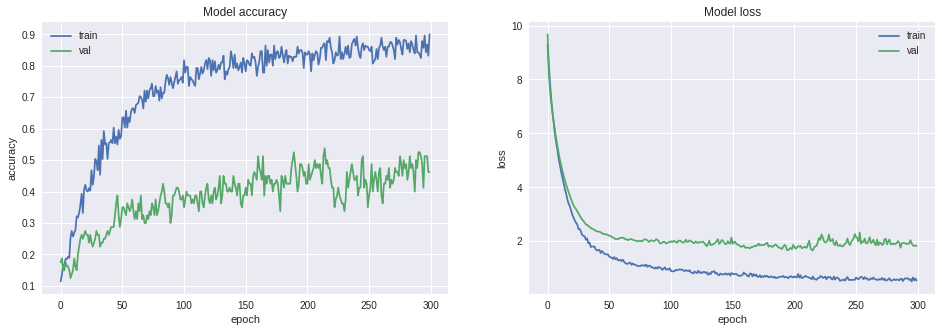

In [ ]:
plt.figure(figsize=(16,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_1D_CNN.history['accuracy'])
plt.plot(history_1D_CNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Loss
plt.subplot(1,2,2)
plt.plot(history_1D_CNN.history['loss'])
plt.plot(history_1D_CNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# best validation accuracy
best_acc = np.max(history_1D_CNN.history['val_accuracy'])
print('Best validation accuracy: {0:5.1f} % '.format(best_acc*100))

Evaluate the model over the test dataset. What is your test accuracy? Is it better or worse than the one in your validation set?

In [ ]:
model_1D_best = tf.keras.models.load_model('1D_CNN.hdf5')

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(model_1D_best.predict(X_test_rs), axis=-1) 
print(y_pred)
print(y_test)
print("Accuracy score: {0:5.1f} % ".format(100*accuracy_score(y_test, y_pred)))

[5 8 6 7 5 3 3 7 5 9 9 3 4 4 8 9 1 2 9 0 4 9 1 5 0 1 2 3 5 7 8 3 9 8 7 6 9
 3 8 6]
[1 8 6 7 6 2 3 3 2 9 1 3 4 7 8 2 1 2 4 0 6 0 1 4 0 1 6 3 5 7 8 7 9 8 7 8 5
 7 0 1]
Accuracy score:  52.5 % 


*Accuracy on the test set is worse than the validation set*

### **Exercise 4**: 1D-CNN Evaluation

Plot your confusion matrix for the validation set and for your test set:

In [ ]:
classlist = list(range(0, 10))
classlist

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

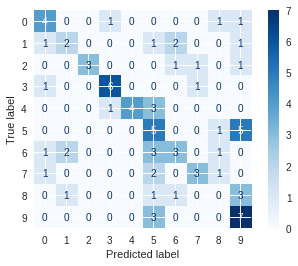

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_val = np.argmax(model_1D_CNN.predict(X_val_rs), axis=-1) 
cm_val = confusion_matrix(y_val, pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=classlist)
disp.plot(cmap='Blues');

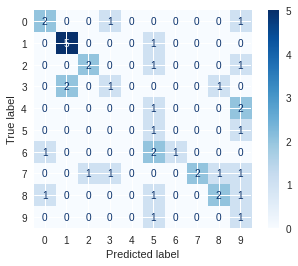

In [ ]:
pred_test = np.argmax(model_1D_CNN.predict(X_test_rs), axis=-1) 
cm_test = confusion_matrix(y_test, pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classlist)
disp.plot(cmap='Blues');

### **Exercise 5**: Time-Distributed 1D-CNN

In the previous 1D-CNN, each band of the Mel-spectrogram was treated as an independent channel. We want to continue using a similar 1D-CNN architecture but this time using a time-distributed model. Now the input will have several time steps (frames in this case) and 1 single channel.

Reshape your input X_train_rs to create a new input X_train_rss with dimensions (280, 216, 128, 1). You can use numpy's expand_dims.

In [ ]:
X_train_rss = np.expand_dims(X_train_rs, axis=3)
X_val_rss = np.expand_dims(X_val_rs, axis=3)
X_test_rss = np.expand_dims(X_test_rs, axis=3)

X_train_rss.shape, X_val_rss.shape, X_test_rss.shape

((280, 216, 128, 1), (80, 216, 128, 1), (40, 216, 128, 1))

Create your time-distributed network. A good thing of time-distributed networks is that the time-step dimension does not have to be fixed (it can be None). Thus, you can specify your input shape as:

input_shape = (None, 128, 1)



In [ ]:
input_shape = (None, X_train_rs.shape[2], 1)

print(input_shape)

(None, 128, 1)


In [ ]:
modeltd = tf.keras.models.Sequential()

# 1st convolutional layer
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=8, kernel_size=9, activation='relu'), input_shape=input_shape))
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')))
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()))

# 2nd convolutional layer
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu')))
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')))
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()))



# flatten output and feed it to a dense layer
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))))
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.7)))


# output layer
modeltd.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, activation='softmax')))

# Reduce the dimension from a sequence to a single value - VERY IMPORTANT
modeltd.add(tf.keras.layers.GlobalAveragePooling1D())

# compile model 
adamopt = tf.keras.optimizers.Adam(learning_rate=0.001)
modeltd.compile(optimizer= adamopt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modeltd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 120, 8)      80        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 60, 8)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 60, 8)       32        
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 58, 16)      400       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29, 16)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29, 16)      64        
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 464)        

Train the model using the same callbacks as before.

In [ ]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

log_file_path = 'training_1D_CNN_TD.log'
csv_logger = CSVLogger(log_file_path, append=False)

patience = 100
early_stop = EarlyStopping('val_loss', patience=patience)

model_name = '1D_CNN_TD.hdf5'
model_checkpoint = ModelCheckpoint(filepath=model_name, monitor='val_accuracy', verbose=1, save_best_only=True)

#Callbacks List
callbacks = [model_checkpoint, csv_logger, early_stop]

In [ ]:
# model fit
history_td = modeltd.fit(X_train_rss,y_train, validation_data = (X_val_rss, y_val), batch_size=32, epochs=300, callbacks=callbacks)

Epoch 1/300
9/9 [==============================] - 2s 94ms/step - loss: 7.9856 - accuracy: 0.0970 - val_loss: 7.0618 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to 1D_CNN_TD.hdf5
Epoch 2/300
9/9 [==============================] - 0s 22ms/step - loss: 6.6793 - accuracy: 0.1781 - val_loss: 5.9287 - val_accuracy: 0.2125

Epoch 00002: val_accuracy improved from 0.10000 to 0.21250, saving model to 1D_CNN_TD.hdf5
Epoch 3/300
9/9 [==============================] - 0s 22ms/step - loss: 5.6005 - accuracy: 0.1861 - val_loss: 5.0250 - val_accuracy: 0.2250

Epoch 00003: val_accuracy improved from 0.21250 to 0.22500, saving model to 1D_CNN_TD.hdf5
Epoch 4/300
9/9 [==============================] - 0s 22ms/step - loss: 4.7310 - accuracy: 0.3120 - val_loss: 4.3312 - val_accuracy: 0.2125

Epoch 00004: val_accuracy did not improve from 0.22500
Epoch 5/300
9/9 [==============================] - 0s 22ms/step - loss: 4.0357 - accuracy: 0.3349 - val_loss: 3

Plot the training history.

Best validation accuracy:  73.8 % 


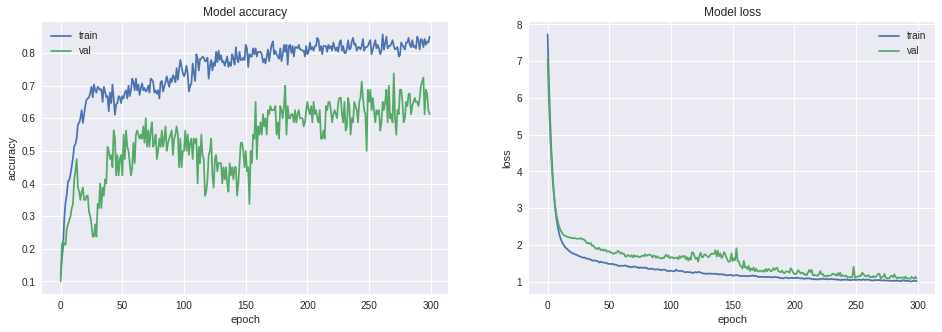

In [ ]:
plt.figure(figsize=(16,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_td.history['accuracy'])
plt.plot(history_td.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Loss
plt.subplot(1,2,2)
plt.plot(history_td.history['loss'])
plt.plot(history_td.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# best validation accuracy
best_acc = np.max(history_td.history['val_accuracy'])
print('Best validation accuracy: {0:5.1f} % '.format(best_acc*100))

*Looking at the training history, the model seems performing better than the one before.*

Plot the validation and test confusion matrices:

In [ ]:
modeltd_best = tf.keras.models.load_model('1D_CNN_TD.hdf5')

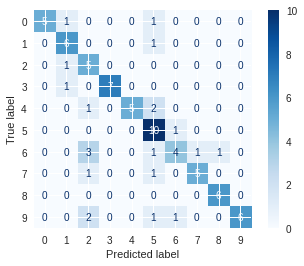

In [ ]:
pred_val = np.argmax(modeltd_best.predict(X_val_rss), axis=-1) 
cm_val = confusion_matrix(y_val, pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=classlist)
disp.plot(cmap='Blues');

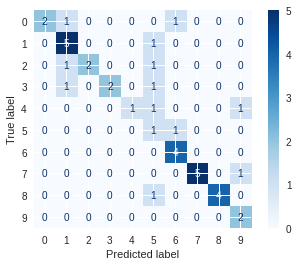

In [ ]:
pred_test = np.argmax(modeltd_best.predict(X_test_rss), axis=-1) 
cm_test = confusion_matrix(y_test, pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classlist)
disp.plot(cmap='Blues');

### **Exercise 6**: Performance metrics

Use sklearn "classification_report" to analyze the performance of the classifier for each class in terms of Precision, Recall and F1.

Show the classification report for evaluation set. Discuss the results.

In [ ]:
from sklearn.metrics import classification_report

pred_val = np.argmax(modeltd_best.predict(X_val_rss), axis=-1)
#print(pred_val)
#print(y_val)

print("Classification report for evaluation set")
print(classification_report(y_val, pred_val))

Classification report for evaluation set
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.67      0.86      0.75         7
           2       0.42      0.83      0.56         6
           3       1.00      0.88      0.93         8
           4       1.00      0.62      0.77         8
           5       0.59      0.91      0.71        11
           6       0.67      0.40      0.50        10
           7       0.83      0.71      0.77         7
           8       0.86      1.00      0.92         6
           9       1.00      0.60      0.75        10

    accuracy                           0.74        80
   macro avg       0.80      0.75      0.75        80
weighted avg       0.80      0.74      0.74        80



*All the measures have high variability. That's because we have a small validation set. It can be seen that some classes have a support of only few examples.*

Show the classification report for the test set. Discuss the results.

In [ ]:
pred_test = np.argmax(modeltd_best.predict(X_test_rss), axis=-1) 

print("Classification report for test set")
print(classification_report(y_test, pred_test))

Classification report for test set
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.62      0.83      0.71         6
           2       1.00      0.50      0.67         4
           3       1.00      0.50      0.67         4
           4       1.00      0.33      0.50         3
           5       0.17      0.50      0.25         2
           6       0.67      1.00      0.80         4
           7       1.00      0.83      0.91         6
           8       1.00      0.80      0.89         5
           9       0.50      1.00      0.67         2

    accuracy                           0.70        40
   macro avg       0.80      0.68      0.67        40
weighted avg       0.84      0.70      0.72        40



*Test set is even smaller. The measures have high variability. However we can see the model is performing well.*

### **Exercise 7**: Hybrid CNN-RNN

In this last exercise we are going to mix our previous time-distributed model with a LSTM layer to create a Hybrid CNN-RNN architecture.

Adapt your previous time-distributed model to match the following summary:

In [ ]:
model_hybrid = tf.keras.models.Sequential()

# 1st convolutional layer
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'), input_shape=input_shape))
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')))
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))

# 2nd convolutional layer
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu')))
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')))
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))

# 3rd convolutional layer 
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')))
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.35)))
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same')))

# flatten output and feed it to a dense layer
model_hybrid.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model_hybrid.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_hybrid.add(tf.keras.layers.GlobalAveragePooling1D())
model_hybrid.add(tf.keras.layers.Dropout(0.35))

# output layer
model_hybrid.add(tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# compile model 
adamopt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_hybrid.compile(optimizer= adamopt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_hybrid.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, None, 120, 16)     160       
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 60, 16)      0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 60, 16)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 58, 16)      784       
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 29, 16)      0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 29, 16)      0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 27, 32)     

In [ ]:
 #_________________________________________________________________
# Layer (type)                 Output Shape              Param #   

# Time-Dist Conv1D             (None, None, 120, 16)     160       
# _________________________________________________________________
# Time-Dist MaxPool1D 1D       (None, None, 60, 16)      0         
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 60, 16)      0         
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 58, 16)      784       
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 29, 16)      0         
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 29, 16)      0         
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 27, 32)      1568      
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 27, 32)      0         
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 14, 32)      0         
# _________________________________________________________________
# Time-Dist Flatten            (None, None, 448)         0         
# _________________________________________________________________
# LSTM  (16 neurons)           (None, None, 16)          29760     
# _________________________________________________________________
# Global Av. Pooling 1D        (None, 16)                0         
# _________________________________________________________________
# Dropout (0.35)               (None, 16)                0         
# _________________________________________________________________
# Dense                        (None, 10)                170       

# Total params: 32,442
# Trainable params: 32,442
# Non-trainable params: 0
# _________________________________________________________________


Train the network.

In [ ]:
history_hybrid = model_hybrid.fit(X_train_rss,y_train, validation_data = (X_val_rss, y_val), batch_size=32, epochs=300, callbacks=callbacks)

Epoch 1/300
9/9 [==============================] - 3s 147ms/step - loss: 2.3323 - accuracy: 0.0708 - val_loss: 2.2550 - val_accuracy: 0.1625

Epoch 00001: val_accuracy did not improve from 0.73750
Epoch 2/300
9/9 [==============================] - 0s 40ms/step - loss: 2.2549 - accuracy: 0.1812 - val_loss: 2.1887 - val_accuracy: 0.2875

Epoch 00002: val_accuracy did not improve from 0.73750
Epoch 3/300
9/9 [==============================] - 0s 40ms/step - loss: 2.1653 - accuracy: 0.2307 - val_loss: 2.1086 - val_accuracy: 0.2750

Epoch 00003: val_accuracy did not improve from 0.73750
Epoch 4/300
9/9 [==============================] - 0s 40ms/step - loss: 2.0754 - accuracy: 0.2883 - val_loss: 2.0218 - val_accuracy: 0.3375

Epoch 00004: val_accuracy did not improve from 0.73750
Epoch 5/300
9/9 [==============================] - 0s 39ms/step - loss: 1.9509 - accuracy: 0.3859 - val_loss: 1.9510 - val_accuracy: 0.3750

Epoch 00005: val_accuracy did not improve from 0.73750
Epoch 6/300
9/9 [==

Plot the training history and evaluate the model. Discuss your results.

Best validation accuracy:  65.0 % 


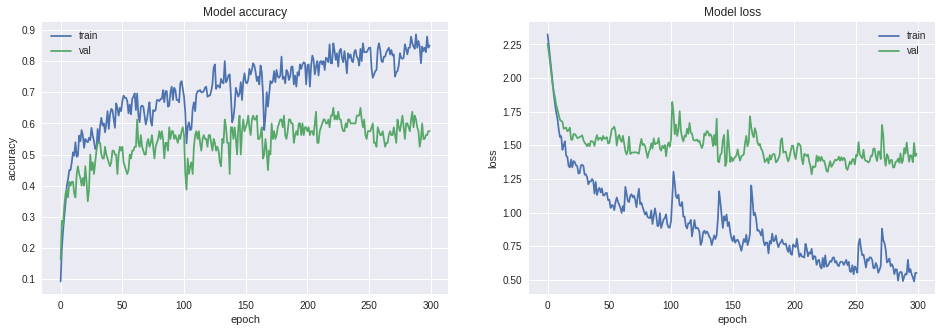

In [ ]:
plt.figure(figsize=(16,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_hybrid.history['accuracy'])
plt.plot(history_hybrid.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Loss
plt.subplot(1,2,2)
plt.plot(history_hybrid.history['loss'])
plt.plot(history_hybrid.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# best validation accuracy
best_acc = np.max(history_hybrid.history['val_accuracy'])
print('Best validation accuracy: {0:5.1f} % '.format(best_acc*100))

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(model_hybrid.predict(X_test_rss), axis=-1) 
print(y_pred)
print(y_test)
print("Accuracy score: {0:5.1f} % ".format(100*accuracy_score(y_test, y_pred)))

[5 8 6 7 0 2 0 3 5 9 9 3 4 9 8 8 4 2 9 6 6 0 1 9 0 5 6 7 5 7 5 3 9 8 2 8 8
 7 0 1]
[1 8 6 7 6 2 3 3 2 9 1 3 4 7 8 2 1 2 4 0 6 0 1 4 0 1 6 3 5 7 8 7 9 8 7 8 5
 7 0 1]
Accuracy score:  57.5 % 


*Accuracy is similar to the model of exercise 6. However we can see from both the accuracy and loss plots our model training is smoother.*